In [ ]:
_=!git clone https://github.com/Sht97/Accelerometer-Gyro-dataset.git dataset
!cd dataset && git pull

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from scikitplot.metrics import plot_confusion_matrix#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.model_selection import train_test_split
from scipy import stats

In [15]:
def get_conv_model_A(num_classes,num_filtros,size_filtros, compile=True):
    
    #print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(300,6), name="input_1")
    layers = tf.keras.layers.Conv1D(num_filtros,size_filtros, activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    if compile:
        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


def train(model,x_train,y_train,x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    h = model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test),verbose=0)
    #metrics = model.evaluate(x_test, y_test)
    return h #{k:v for k,v in zip (model.metrics_names, metrics)}

In [16]:
archivos  = ['Daniel/Activacion','Daniel/Complejo','Daniel/Encender','Daniel/X'
             ,'Raul/Activacion','Raul/Complejo','Raul/Encender','Raul/X']
archivos2 = ['Daniel/Encender','Raul/Encender','Daniel/Complejo','Raul/Complejo','Daniel/X','Raul/X']

 
G0 = ['Daniel/Activacion','Raul/Activacion']  # 0
G1 = ['Daniel/Encender','Raul/Encender']    # 1 
G2 = ['Daniel/Complejo','Raul/Complejo']    # 2
G3 = ['Daniel/X','Raul/X']           # 3

x = []
y = []
for archivo in archivos:
    df1=pd.read_csv('dataset/'+ archivo +'.csv')

    cambios=df1[df1['Tiempo']=='Order'].index.tolist()

    for i in cambios:
        gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
        gesto1 = gesto1.to_numpy()

        m=np.fft.rfft(gesto1[:,2:8],axis=0)
        f=30
        ones=np.ones(f)
        zeros=np.zeros(m.shape[0]-f)
        c=np.concatenate((ones,zeros))
        clean=m*c.reshape(m.shape[0],1)
        m=np.fft.irfft(clean,axis=0)
        x.append(m)

#         x.append(gesto1[:,2:8])

        if archivo in G0:
            y.append(0)
        elif archivo in G1:
            y.append(1)
        elif archivo in G2:
            y.append(2)
        else:
            y.append(3)



x = np.array(x)
y = np.array(y)

x = (x+32762)/65536
xSet1, xSet2, ySet1, ySet2  = train_test_split(x, y, test_size=1/3)
xSet1, xSet3, ySet1, ySet3, = train_test_split(xSet1, ySet1, test_size=0.5)

xSets = np.array([xSet1,xSet2,xSet3])
ySets = np.array([ySet1,ySet2,ySet3])


print(xSet1.shape)
print(xSet2.shape)
print(xSet3.shape)

(542, 300, 6)
(542, 300, 6)
(542, 300, 6)


In [23]:

datos = {'batch_size': [],
        'sizeFilter': [],
        'numFilter': [],
        'LssTrain': [],
        'AccTrain': [],
        'LssVal': [],
        'AccVal': []
        }

datos = pd.DataFrame(datos, columns = ['batch_size','sizeFilter','numFilter','LssTrain','AccTrain','LssVal','AccVal'])

contador = 0
contador2 = 0
modelosE = [11,12,13,15,19,21]
for i in [10,100]:
    for j in [10,50,100]:
        for k in [5,10,20,30]:
            if contador in modelosE:
                model = get_conv_model_A(4,k,j)
                x_train,x_test,y_train,y_test = train_test_split(xSets[contador2%3],ySets[contador2%3])
                
                a = train(model,x_train,y_train,x_test,y_test, batch_size=i, epochs=2000, model_name="model_A")
                model.save('./modelos/mejores6/modelo_bs'+str(i)+'_sf'+str(j)+'_nf'+str(k)+'.h5')


                fila = {'batch_size': [i],
                        'sizeFilter': [j],
                        'numFilter': [k],
                        'LssTrain': [a.history['loss']],
                        'AccTrain': [a.history['accuracy']],
                        'LssVal': [a.history['val_loss']],
                        'AccVal': [a.history['val_accuracy']]
                        }


                fila = pd.DataFrame(fila, columns = ['batch_size','sizeFilter','numFilter','LssTrain','AccTrain','LssVal','AccVal'])
                datos = datos.append(fila,ignore_index=True)    
                contador2+=1
            contador+=1
            print(contador)
datos.to_csv('6 mejores modelos con diferentes 3 diferenntes splits.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [27]:
datos

,batch_size,sizeFilter,numFilter,LssTrain,AccTrain,LssVal,AccVal
0,10.0,100.0,30.0,"[1.3961583375930786, 1.3925261497497559, 1.384...","[0.29064038395881653, 0.2536945939064026, 0.26...","[1.3798964023590088, 1.380872368812561, 1.3800...","[0.29411765933036804, 0.34558823704719543, 0.2..."
1,100.0,10.0,5.0,"[1.4063640832901, 1.4101371765136719, 1.395181...","[0.26354679465293884, 0.2536945939064026, 0.26...","[1.3816932439804077, 1.38359534740448, 1.38004...","[0.3235294222831726, 0.22058823704719543, 0.25..."
2,100.0,10.0,10.0,"[1.3987873792648315, 1.3912278413772583, 1.388...","[0.28817734122276306, 0.28325122594833374, 0.2...","[1.3949650526046753, 1.391444206237793, 1.4005...","[0.23529411852359772, 0.19117647409439087, 0.1..."
3,100.0,10.0,30.0,"[1.386960506439209, 1.3913096189498901, 1.3798...","[0.2142857164144516, 0.21921181678771973, 0.28...","[1.3795366287231445, 1.3798611164093018, 1.376...","[0.2720588147640228, 0.3235294222831726, 0.286..."
4,100.0,50.0,30.0,"[1.4119036197662354, 1.3910019397735596, 1.386...","[0.23152709007263184, 0.2807881832122803, 0.26...","[1.390299677848816, 1.39328932762146, 1.400824...","[0.2132352888584137, 0.2132352888584137, 0.213..."
5,100.0,100.0,10.0,"[1.3886522054672241, 1.3821251392364502, 1.379...","[0.27093595266342163, 0.2783251106739044, 0.28...","[1.3860204219818115, 1.387305498123169, 1.3888...","[0.25735294818878174, 0.25735294818878174, 0.2..."


0


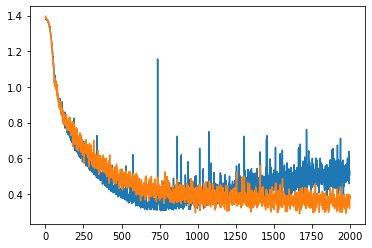

1


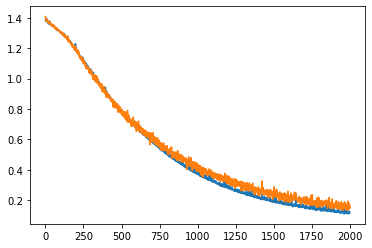

2


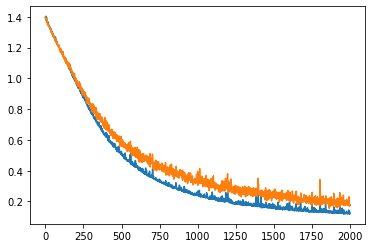

3


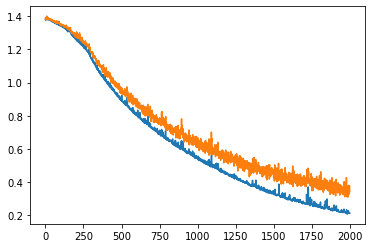

4


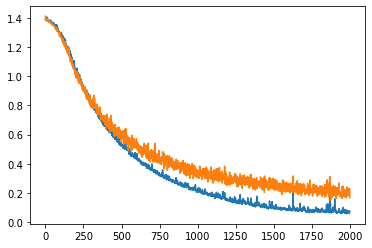

5


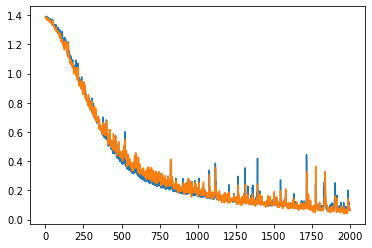

In [28]:
for i in range(6):
    curba1 = datos[datos.index == i]['LssVal'].tolist()
    curba2 = datos[datos.index == i]['LssTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

0


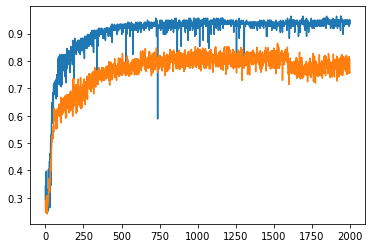

1


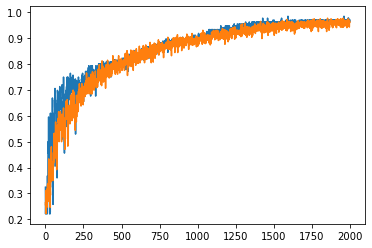

2


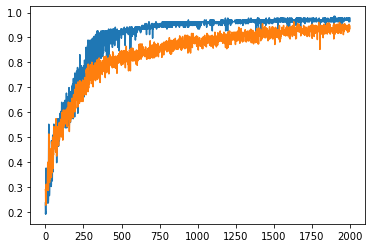

3


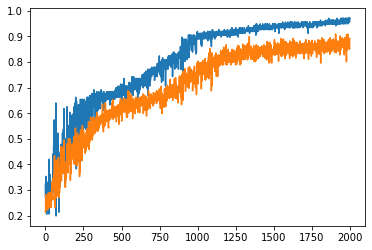

4


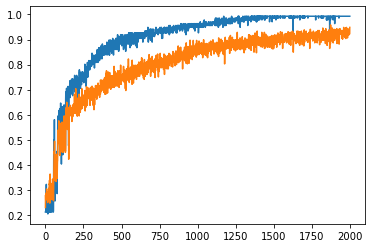

5


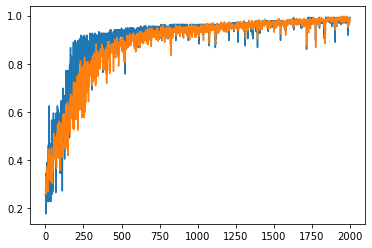

In [29]:
for i in range(6):
    curba1 = datos[datos.index == i]['AccVal'].tolist()
    curba2 = datos[datos.index == i]['AccTrain'].tolist()
    print(i)
    plt.plot(curba1[0])
    plt.plot(curba2[0])
    plt.show()

In [30]:
df1=pd.read_csv('Muestras/PruebaAgena.csv')

cambios=df1[df1['Tiempo']=='Order'].index.tolist()

contador = 0
x= []
y=[]
for i in cambios:
    gesto1=df1[(df1.index>=i-300)&(df1.index<i)].astype(int)
    gesto1 = gesto1.to_numpy()

    m=np.fft.rfft(gesto1[:,2:8],axis=0)
    f=30
    ones=np.ones(f)
    zeros=np.zeros(m.shape[0]-f)
    c=np.concatenate((ones,zeros))
    clean=m*c.reshape(m.shape[0],1)
    m=np.fft.irfft(clean,axis=0)
    x.append(m)

#   x.append(gesto1[:,2:8])

y=[1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,2,2,2,2,2,0,0,0,0,0]
x = np.array(x)
y = np.array(y)
x = (x+32762)/65536
print(x.shape)

(60, 300, 6)


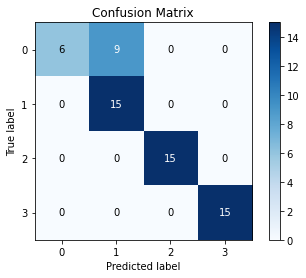

In [31]:
model =  tf.keras.models.load_model('./modelos/modelo_bs100_sf10_nf10.h5')
test_preds = model.predict(x).argmax(axis=1)
plot_confusion_matrix(y, test_preds, normalize=False)